In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [2]:
seed = 0

In [3]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [7]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(min_child_weight=0),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=100,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


/tmp/ipykernel_5480/4227150075.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-04 15:12:12,544] A new study created in memory with name: no-name-2bd78c44-1af4-4b9d-bcf4-42432d987f67
[I 2023-11-04 15:12:12,952] Trial 0 finished with value: 0.7502334126218055 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-04 15:12:13,072] Trial 1 finished with value: 0.749655411150947 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-04 15:12:13,136] Trial 2 finished with value: 0.5663926043390328 and parameters: {'n_estimators': 5, '

In [11]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.913257,0.866337,0.133663,0.364298,0.657037,0.850534,0.921053,train_g0
1,0.903525,0.831169,0.168831,0.415325,0.657037,0.831933,0.901408,train_g1
2,0.750558,0.747368,0.252632,0.494535,0.657037,0.726562,0.865854,test_g0
3,0.755745,0.808511,0.191489,0.548385,0.657037,0.722222,0.775510,test_g1


In [12]:
best_params = model_search.best_params_
best_params

{'n_estimators': 47,
 'eta': 0.2832661171775745,
 'max_leaves': 17,
 'colsample_bytree': 0.5567972215094216,
 'max_depth': 9,
 'l2_weight': 32.30950456746433}

## Model with dual step

### Experiment 1

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize ROC. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [16]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(min_child_weight=0, objective = models.penalize_max_loss_subgroups(0, 1)),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=100,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_5480/3316820745.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-04 15:13:41,719] A new study created in memory with name: no-name-d1e33b0d-d57d-490f-824f-8c6e9e10e0cb


[I 2023-11-04 15:13:43,235] Trial 0 finished with value: 0.7537716606913035 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7537716606913035.
[I 2023-11-04 15:13:43,899] Trial 1 finished with value: 0.7521164420159956 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7537716606913035.
[I 2023-11-04 15:13:44,173] Trial 2 finished with value: 0.5892487273625667 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.7537716606913035.
[I 2023-11-04 15:13:45,315] Trial 3 finished with value: 0.7532960734969663 and parameters: {'n_estimators': 20, 'eta': 0

In [17]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 44,
 'eta': 0.2860467516877492,
 'max_leaves': 31,
 'colsample_bytree': 0.8581636626155605,
 'max_depth': 8,
 'l2_weight': 76.60589386893972}

In [18]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.924223,0.891089,0.108911,0.356204,0.632863,0.866548,0.920716,train_g0
1,0.907236,0.863636,0.136364,0.418062,0.632863,0.848739,0.898649,train_g1
2,0.725359,0.778947,0.221053,0.504204,0.632863,0.734375,0.850575,test_g0
3,0.772766,0.872340,0.127660,0.539346,0.632863,0.750000,0.773585,test_g1


In [19]:
lambda_values = np.append([0],np.logspace(-6, 6, num=24))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(0, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


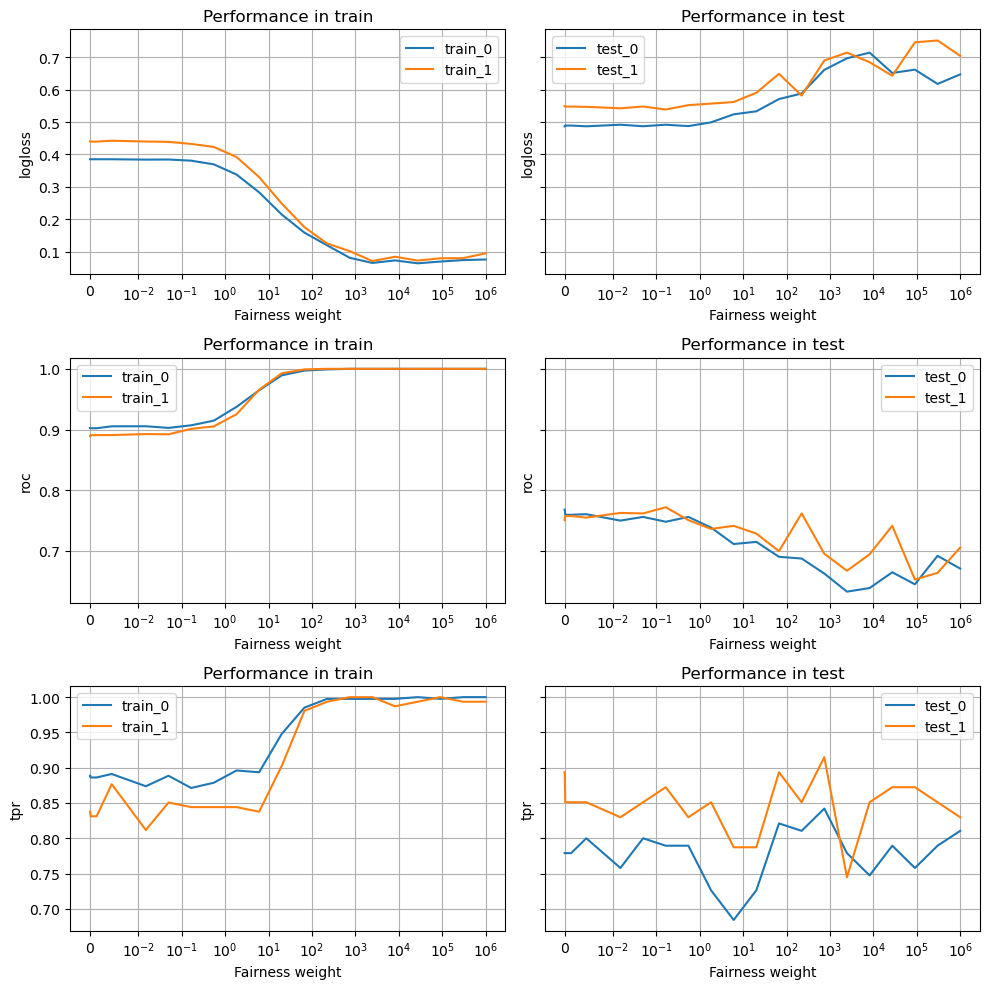

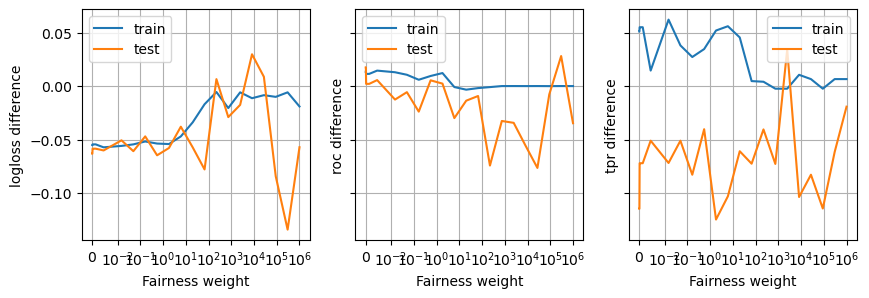

In [29]:
utils.comparison_subgrous_metrics_lambda(results)